# Objective : Given a video choose some fixed (16) number of frames, as unique as possible

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=9b181e918d04893ac06a4dad986c91fbfc54980afca363200926dd541bbfc407
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
import numpy as np
import matplotlib.pyplot as plt
import os

Downloading the video and getting the frames

In [ ]:
VIDEO_LINK = "https://video.twimg.com/amplify_video/1333483086185697283/vid/1280x720/7GmOiNZ0KOZFVOcP.mp4?tag=13%27,%20bitrate=2176000),%20VideoVariant(contentType=%27video/mp4"

In [ ]:
wget.download(VIDEO_LINK,"vid.mp4")

'vid.mp4'

In [ ]:
#getting the frames
import cv2

def extract_frames(video_path,size = (224,224)):
    frames = []

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    frame_count = 0

    while True:
        # Read a frame from the video
        ret, frame = cap.read()

        # Break the loop if the video has ended
        if not ret:
            break

        # Append the frame to the list
        frame = cv2.resize(frame,size)
        frames.append(frame)

        frame_count += 1

    # Release the video capture object
    cap.release()

    print(f"Frames extracted: {frame_count}")

    return frames






In [ ]:
# Replace 'input_video.mp4' with your video file
input_video_path = 'vid.mp4'

# Get the list of frames
frames_list = extract_frames(input_video_path)

Frames extracted: 2318


In [ ]:
def plot_images(images, k=5, rows=1, figsize=(15, 3)):

    if k > len(images):
        print("Warning: The number of images to plot (k) is greater than the total number of images.")
        k = len(images)

    fig, axes = plt.subplots(rows, k // rows, figsize=figsize)

    for i in range(k):
        ax = axes[i // (k // rows), i % (k // rows)] if rows > 1 else axes[i]
        ax.imshow(images[i])  # Assuming grayscale images
        ax.axis('off')

    plt.show()



In [ ]:
frames_list[0].shape

(224, 224, 3)

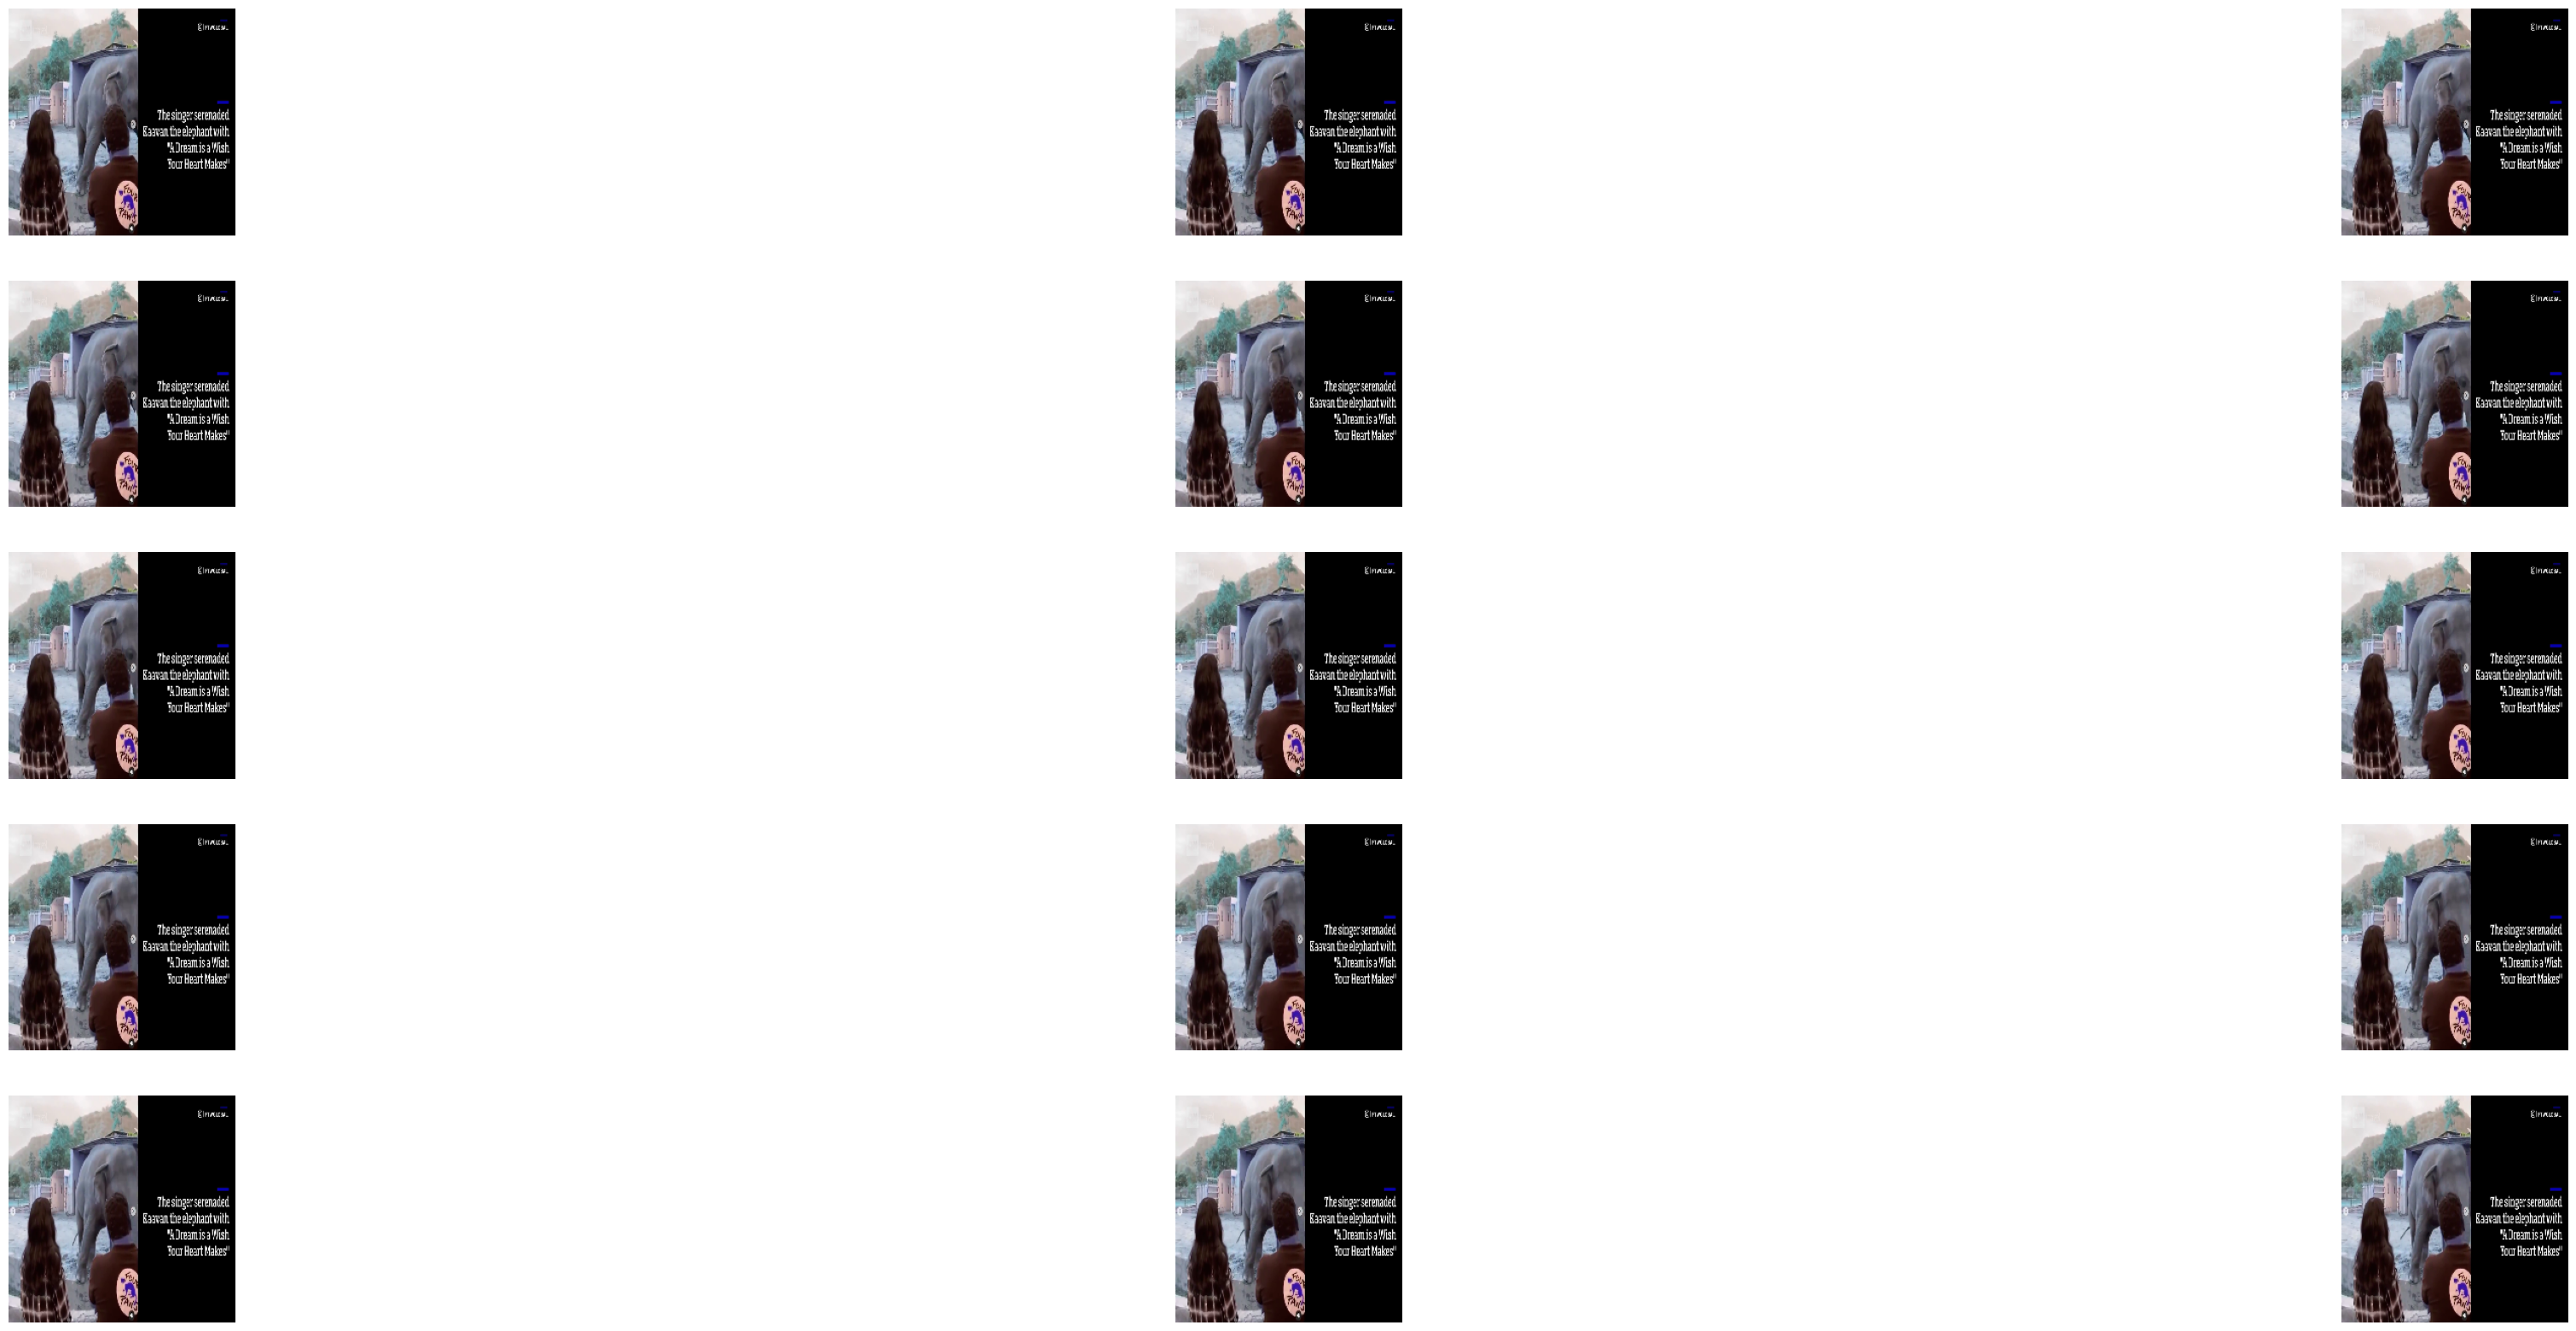

In [ ]:
plot_images(frames_list[400:],15,5,(50,20))

Extracting features from a frame

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

def extract_and_downsample_features(img, layer_name='conv4_block1_out'):
    # Load the ResNet50 model pre-trained on ImageNet
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Load and preprocess the input image
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = preprocess_input(img_array)

    # Get features from the specified layer
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = intermediate_layer_model.predict(img_array)

    # Global Average Pooling (GAP) layer to downsample to a 512-dimensional array
    gap_layer = tf.keras.layers.GlobalAveragePooling2D()
    downsampled_features = gap_layer(features)

    return downsampled_features



In [ ]:
frame = frames_list[0]

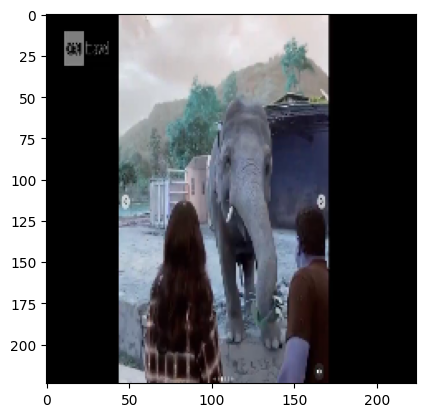

In [ ]:
plt.imshow(frame)

In [ ]:

extracted_features = extract_and_downsample_features(frame,layer_name = 'conv5_block3_out')
print("Extracted features shape:", extracted_features.shape)


1/1 [==============================] - 13s 13s/step
Extracted features shape: (1, 2048)


In [ ]:
from scipy.spatial.distance import euclidean
def compare_features(features1, features2, threshold=10.0):
    # Calculate Euclidean distance between the two feature vectors
    distance = euclidean(features1, features2)
    print(f"distance is {distance} lol")
    # Compare distance with the threshold
    if distance > threshold:
        # print('dissimilar')
        return 1
    else:
        # print('similar')
        return 0

In [ ]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
feat1 = extract_and_downsample_features(frames_list[0]).reshape(-1)


1/1 [==============================] - 0s 477ms/step


In [ ]:
feat2 = extract_and_downsample_features(frames_list[1000]).reshape(-1)

1/1 [==============================] - 0s 491ms/step


In [ ]:
feat1.shape

TensorShape([1024])

In [ ]:
import time

start = time.time()
feat1 = extract_and_downsample_features(frames_list[0]).reshape(-1)
indices = [0]
jump = 75
for i in range (1,len(frames_list)//jump):
  feat2 = extract_and_downsample_features(frames_list[jump*i+1]).reshape(-1)
  if(compare_features(feat1,feat2)):
    print(f'dissimilar at {5*i}')
    feat1=feat2
    indices.append(jump*i+1)


end = time.time()


# Calculate the elapsed time
elapsed_time = end - start

# Print the time spent in seconds
print(f"Time spent: {elapsed_time} seconds")


1/1 [==============================] - 1s 506ms/step


1/1 [==============================] - 1s 511ms/step
distance is 2.1776344776153564 lol


1/1 [==============================] - 1s 791ms/step
distance is 5.67037296295166 lol
1/1 [==============================] - 1s 581ms/step
distance is 6.1413702964782715 lol
1/1 [==============================] - 0s 497ms/step
distance is 6.349823951721191 lol
1/1 [==============================] - 0s 486ms/step
distance is 6.40490198135376 lol
1/1 [==============================] - 0s 466ms/step
distance is 10.989021301269531 lol
dissimilar at 30
1/1 [==============================] - 1s 863ms/step
distance is 2.6187446117401123 lol
1/1 [==============================] - 1s 730ms/step
distance is 3.035468101501465 lol
1/1 [==============================] - 0s 475ms/step
distance is 10.848793983459473 lol
dissimilar at 45
1/1 [==============================] - 0s 462ms/step
distance is 10.497679710388184 lol
dissimilar at 50
1/1 [==============================] - 0s 463ms/step
distance is 9.013644218444824 lol
1/1 [==============================] - 0s 476ms/step
distance is 13.25934982

In [ ]:
len(frames_list)//jump

30

In [ ]:
distinct_frames = [frames_list[j] for j in indices]

In [ ]:
len(distinct_frames)

12

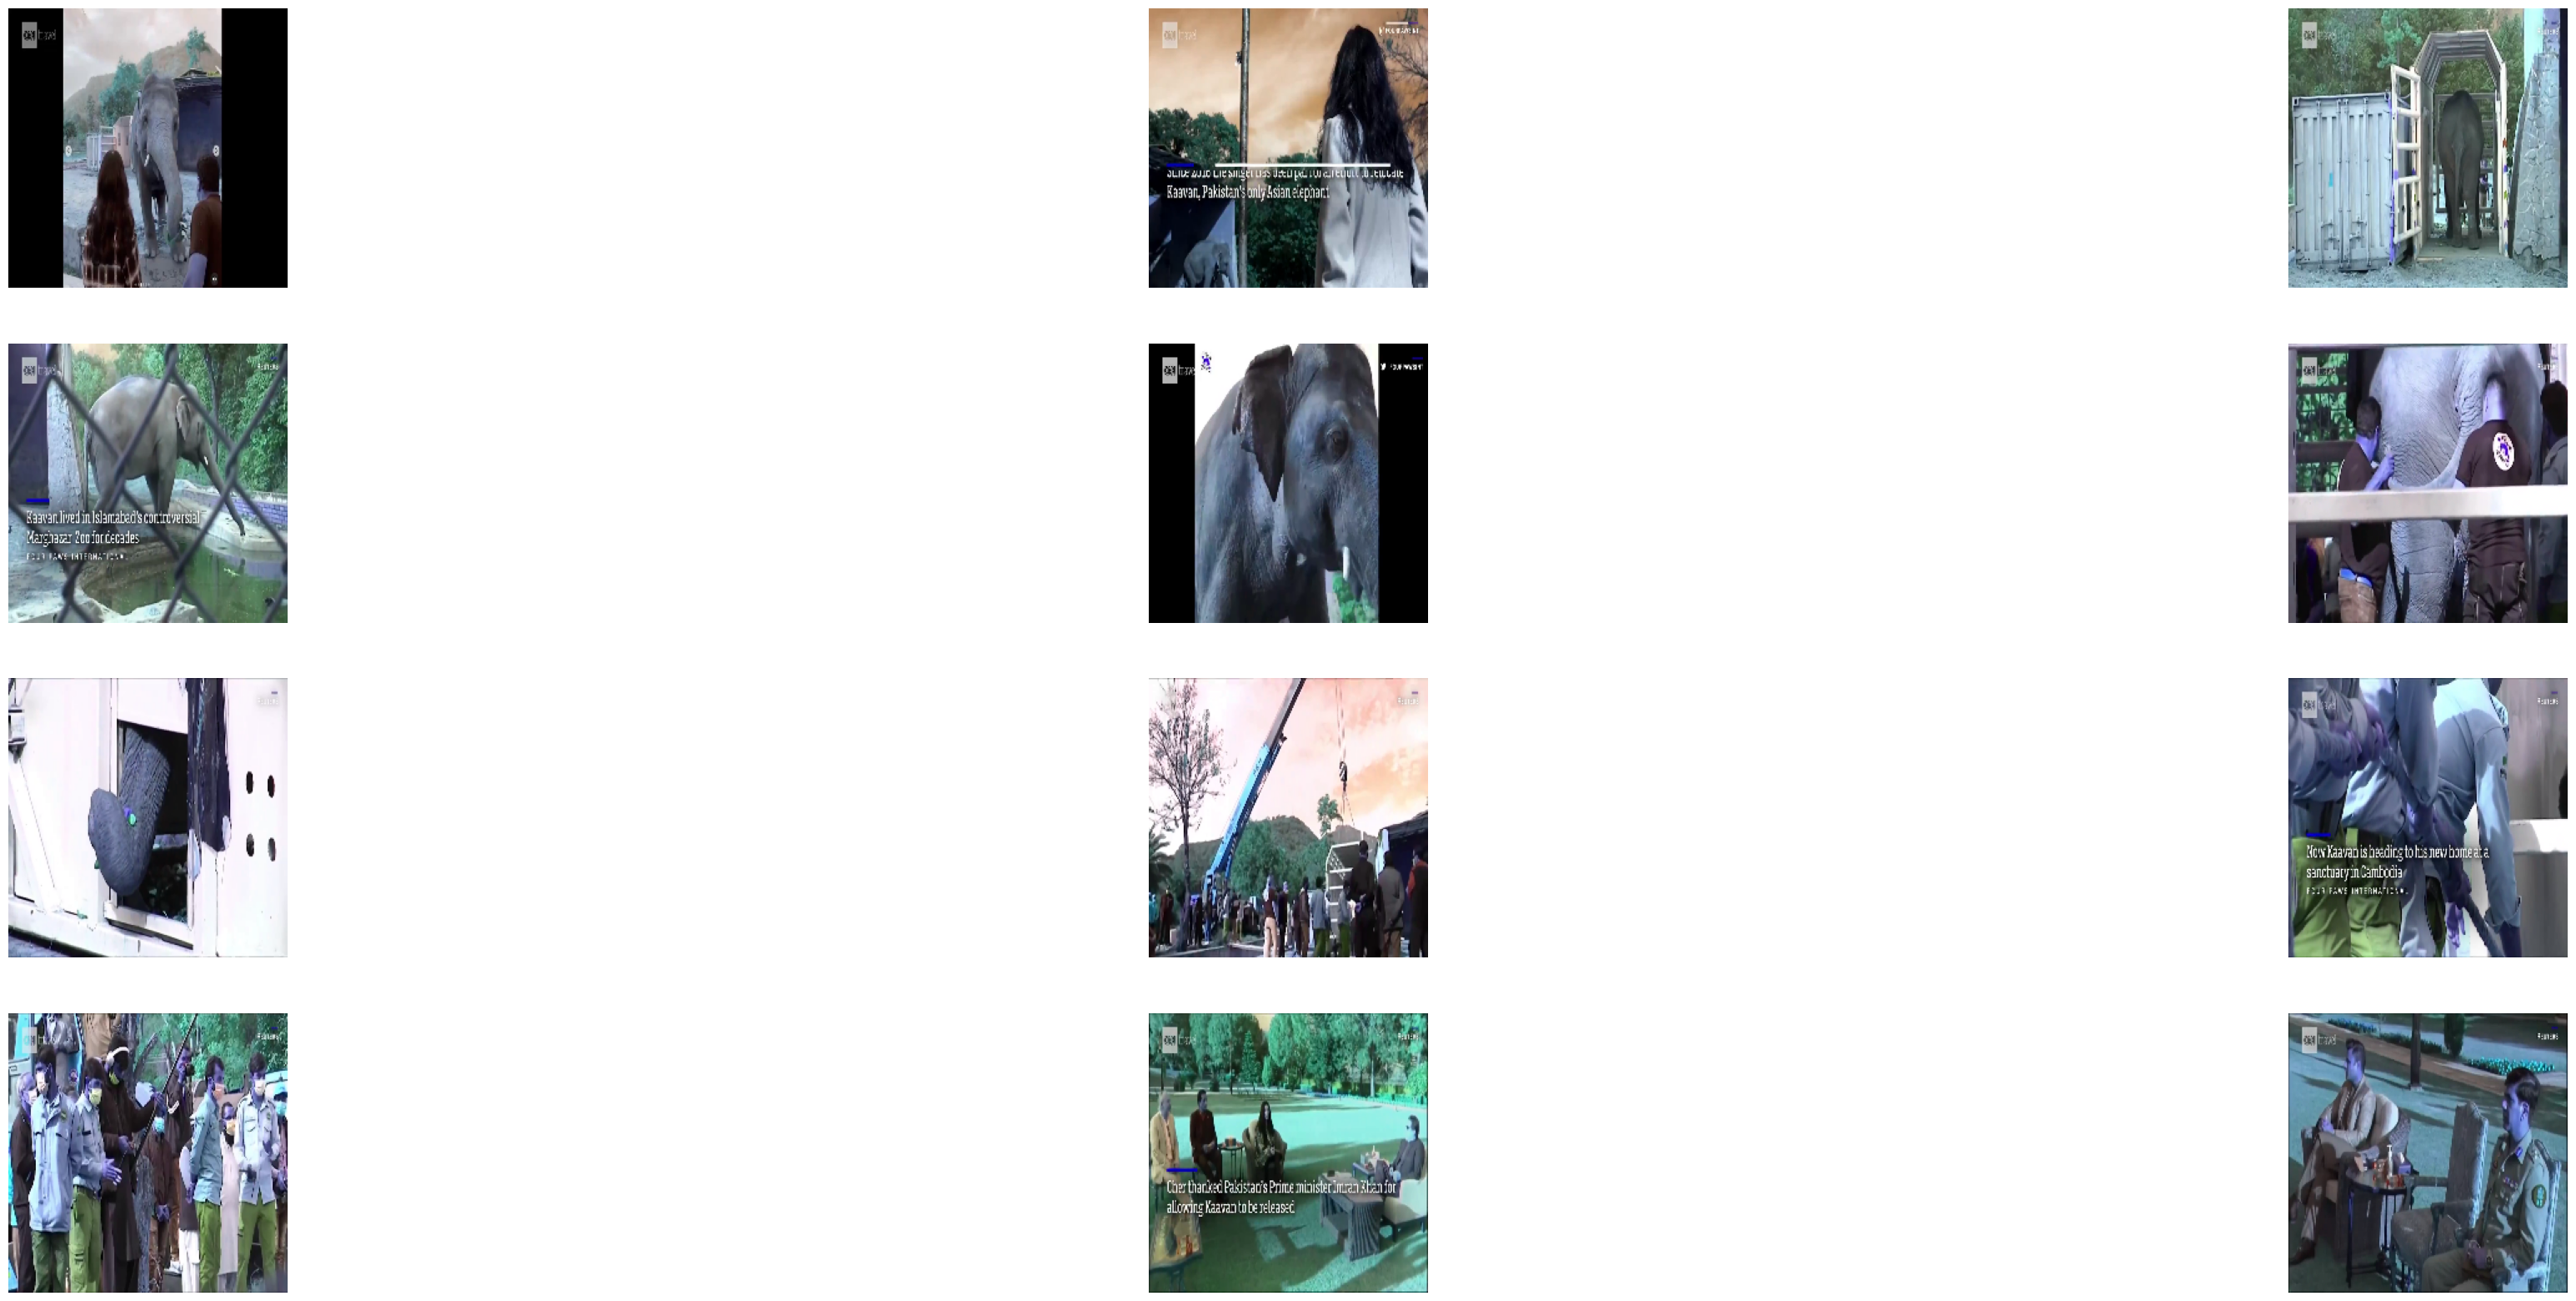

In [ ]:
plot_images(distinct_frames,12,4,(50,20))